# Reproducibility
---
You can follow this Jupyter Notebook in order to reproduce the figure 3 of our paper about reproducibility in bioinformatics ([Kim et al. BioRxiv 2017](http://www.biorxiv.org/content/early/2017/06/20/143503)).

Our StratiPy project is based on NBS (Network Based Stratification) method ([Hofree et al. Nat. Meth. 2013](http://www.nature.com/nmeth/journal/v10/n11/full/nmeth.2651.html)).

---

# 1 - Before starting work

## 1.1 - Virtual environment
We recommend that you use this Python 3 project in a virtual environment.
For anaconda users, you can activate a virtual environment with:
```
~$ conda create -n <your_environment_name> python=3.6 anaconda
```

Then you can activate your virtual environment with:
```
~$ source activate <your_environment_name>
```

When you want to deactivate your virtual environment:
```
~$ source deactivate
```

More details on [Conda's environments](https://conda.io/docs/user-guide/tasks/manage-environments.html).

---

## 1.2 - Data

- General input data was downloaded from [original author's NBS website](http://chianti.ucsd.edu/~mhofree/NBS/). In the original study, authors worked on:
    - 4 types of cancer data provided by [TCGA](https://cancergenome.nih.gov/). Here we only work on uterine endometrial carcinoma (uterine cancer) with 248 patients' somatic mutation data.
    - 3 types of Protein-Protein Interaction (PPI) networks. Here we only utilize [STRING database](https://string-db.org/).
- [data](../data/) folder includes input and output data such as mutation profiles, PPI networks, similarity matrices, etc...
- In this case study, the code will take general input data from [data](../data/) folder but output will be placed in the specific [reproducibility data](reproducibility_data/). Original MATLAB results (100 and 1000 permutations of bootstrap) are also in reproducibility data folder.
- Result's filename will be constituted by parameters' value. If there is same filename, the code will not create new file. If you want to create a new one, you have to remove previous file from the specific [reproducibility data](reproducibility_data/).

---

## 1.3 - Parameters
There are several tuning parameters of NBS. In order to reproduce same result, you only use same values outlined in the original NBS study except two ajustable parameters.

1. **Graph regulator factor (lambda)** is the most influential parameter in this case study. It was thought that this factor had to be a constant value of 1 until we found that its value was changing and converged to 1800. Here you run StratiPy with lambd = 1 and 1800 in order to compare them.
2. **Permutation number of bootstrap** utilized in the original study is 1000. But we recommand to start with 100 permutations since this step is highly time consuming (optimization ongoing ).

Details about each parameter are explained in docstring of [reproducibility.py](reproducibility.py).

In [ ]:
# Defalut settings
data_folder = '../data/' 
patient_data = 'TCGA_UCEC' # Uterine endometrial carcinoma (uterine cancer) with 248 patients' somatic mutation data
ppi_data = 'STRING' # STRING PPI network database
influence_weight = 'min' # Influence weight of propagation on the network
simplification = True # Simplification after propagation
compute = True
overwrite = False
alpha = 0.7 # Diffusion (propagation) factor
tol = 10e-3 # Convergence threshold during diffusion
ngh_max = 11 # Number of best influencers in PPI network
keep_singletons = False
min_mutation = 10
max_mutation = 200000
qn = 'mean' # Quantile normalization (QN) after diffusion is based on the mean of ranked values
n_components = 3 # Desired number of subgroups (clusters)
run_bootstrap = True
run_consensus = True
tol_nmf = 1e-3 # Convergence threshold of NMF and GNMF algorithm
linkage_method = 'average' # Linkage method of hierarchical clustering

# 2 - Let's launch!
Import code

In [ ]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))
from stratipy import load_data, formatting_data, filtering_diffusion, clustering, hierarchical_clustering
from nbs_functions import all_functions
import scipy.sparse as sp
from scipy.io import loadmat, savemat
import numpy as np
import time
import datetime
from IPython.display import Image, display
from importlib import reload

<img style="float: right;" src="img/lamb1.svg">

## 2.1 - With Graph regulator factor (lambda) = 1 

In [ ]:
lambd = 1
n_permutations = 100

### ! ! ! Clustering part will take few hours ! ! !

In [ ]:
lambd1_perm100 = all_functions(data_folder, patient_data, ppi_data, influence_weight,
                               simplification, compute, overwrite, alpha, tol, ngh_max,
                               keep_singletons, min_mutation, max_mutation, qn, n_components,
                               n_permutations, run_bootstrap, run_consensus, lambd, tol_nmf,
                               linkage_method)

<img style="float: right;" src="img/lamb1800.svg">
## 2.2 - With Graph regulator factor (lambda) = 1800

In [ ]:
lambd = 1800

### ! ! ! Clustering part will take few hours ! ! !  (yes, once again) 

In [ ]:
lambd1800_perm100 = all_functions(data_folder, patient_data, ppi_data, influence_weight,
                                  simplification, compute, overwrite, alpha, tol, ngh_max,
                                  keep_singletons, min_mutation, max_mutation, qn,
                                  n_components, n_permutations, run_bootstrap, run_consensus,
                                  lambd, tol_nmf, linkage_method)

# 3 - Reproducibility analyses
## 3.1 - Permutation number of bootstrap: 100 vs 1000, original work

Due to time-comsuming task of bootstrap, we launched StratiPy with 100 permutations instead of 1000 which was proposed in the original NBS work. However you can always launch StratiPy with 1000 permutations if you want (you have to set "n_permutations = 1000").

<img style="float: right;" src="img/matlab.svg">
In [reproducibility data](reproducibility_data/), you can find results provided by original work with 100 and 1000 permutations.
Before comparing testing results of StratiPy (Python), we have to verify whether any significant difference exists between 100 and 1000 permutations

![1](img/confusion_matrices_1.svg)

### Load cluster index of each patients from original results (NBS)

In [ ]:
from confusion_matrices import get_cluster_idx, repro_confusion_matrix
%matplotlib inline
result_folder_repro = "reproducibility_output/"

In [ ]:
# 100 and 1000 permutations of bootstrap
nbs_100 = get_cluster_idx(result_folder_repro, method='nbs',
                          n_permutations=100)
nbs_1000 = get_cluster_idx(result_folder_repro, method='nbs',
                           n_permutations=1000, replace_1by2=True)

### Confusion matrix
plot and save

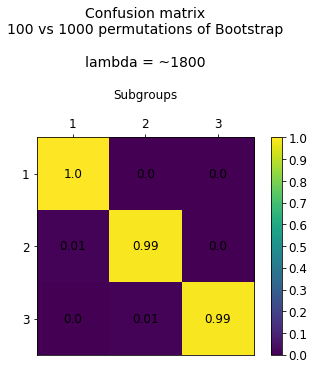

In [ ]:
repro_confusion_matrix(result_folder_repro, data1=nbs_100, data2=nbs_1000,
                       plot_title='Confusion matrix\n100 vs 1000 permutations of Bootstrap',
                       param_value='lambda = ~1800')

**Confusion matrix**: each row or column corresponds to a subgroup of patients (here three subgroups). The diagonal elements show the frequency of correct classifications for each
subgroup: **a high value indicates a correct prediction.**


As you can see, there is no significant difference between 2 results (100 vs 1000 permutations). We will now focus only on 100 permutations of Bootstrap.

## 3.2 - Graph regulator factor (lambda): 1 vs 1800, NBS vs StratiPy

![2](img/confusion_matrices_2.svg)

### Load cluster index of each patients from previously obtained results (StratiPy)

In [ ]:
# lambda 1 and 1800, both 100 permutations of bootstrap
stp_100_lamb1 = get_cluster_idx(result_folder_repro, method='stratipy',
                                n_permutations=100, replace_1by2=True, lambd=1)
stp_100_lamb1800 = get_cluster_idx(result_folder_repro, method='stratipy',
                                   n_permutations=100, replace_1by2_2by3_3by1=True, lambd=1800)

### Confusion matrices

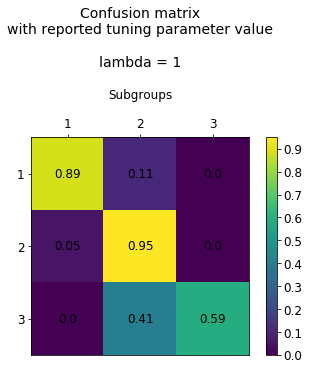

In [ ]:
# between NBS and StratiPy (lambda = 1)
repro_confusion_matrix(result_folder_repro, data1=nbs_100, data2=stp_100_lamb1,
                       plot_title='Confusion matrix\nwith reported tuning parameter value',
                       param_value='lambda = 1')


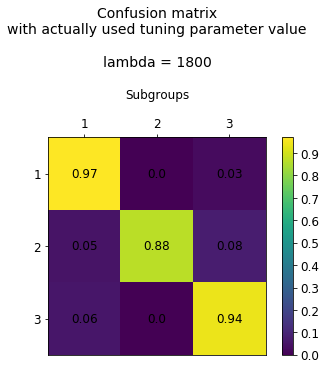

In [ ]:
# between NBS and StratiPy (lambda = 1800)
repro_confusion_matrix(result_folder_repro, data1=nbs_100, data2=stp_100_lamb1800,
                       plot_title='Confusion matrix\nwith actually used tuning parameter value',
                       param_value='lambda = 1800')